In [1]:
from plotly import graph_objects as go

In [2]:
import torch
import torchvision
from torch import nn
# print(torch.__version__)
# print(torchvision.__version__)

In [3]:
from torchvision import transforms
from modularized.engine import vggTrainingInfer, build_engine
from modularized.data_processes import get_data, create_dataloaders

In [4]:
import numpy as np
from PIL import Image
# example image:
np.asarray(Image.open('data/pizza_steak_sushi/test/pizza/194643.jpg')).shape

(512, 382, 3)

In [5]:
import matplotlib.pyplot as plt
from torchinfo import summary

In [6]:
device='cpu'

In [7]:
train_dir, test_dir=get_data(
    data_path='data/pizza_steak_sushi',
    data_url='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip',
    unzip=True,
)


In [8]:
# auto creation of transformations
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transforms=weights.transforms()

# automatic transformations
train_dataloader, test_dataloader, class_names, class_dict = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    img_size=(
        auto_transforms.crop_size[0], auto_transforms.crop_size[0]
    ),
    transformations=auto_transforms,
    batch_size=16,
    num_workers=4,
)

In [9]:
model=torchvision.models.efficientnet_b0(pretrained=True).to(device)

/Users/daweili/Desktop/learning/AIML/repos/re-pytorch/env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/daweili/Desktop/learning/AIML/repos/re-pytorch/env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# getting a summary of our model with torchinfo.summary()
summary(
    model, 
    input_size=(1,3,224,224),
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [11]:
# freezing the base model and chaging the output layer to suit the needs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

for param in model.features.parameters():
    param.requires_grad=False

# Update the classifier head of our model to suit the problem
model.classifier=nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(
        in_features=1280,
        out_features=len(class_names)
    )
).to(device)

In [12]:
# setting up loss function and optimizer
loss_fn=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(
  model.parameters(),
  lr=5e-4
)

# create engine and train
print('performing training of the model')
model, results=build_engine(
  model=model,
  loss_fn=loss_fn,
  optimizer=optimizer,
  train_dataloader=train_dataloader,
  test_dataloader=test_dataloader,
  epochs=20,
  device=device
)

performing training of the model


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train loss: 1.0750734011332195 | train_acc: 0.475
test loss: 0.9259948849678039 | test_acc: 0.6659090909090909
Epoch: 1 | train loss: 0.9110634644826253 | train_acc: 0.6875
test loss: 0.8468975305557251 | test_acc: 0.7284090909090909
Epoch: 2 | train loss: 0.8094622413317363 | train_acc: 0.7666666666666667
test loss: 0.7480541110038758 | test_acc: 0.8636363636363636
Epoch: 3 | train loss: 0.7847193439801534 | train_acc: 0.6875
test loss: 0.7082570672035218 | test_acc: 0.8261363636363637
Epoch: 4 | train loss: 0.7024192055066426 | train_acc: 0.7625
test loss: 0.629297399520874 | test_acc: 0.8693181818181819
Epoch: 5 | train loss: 0.6571242650349934 | train_acc: 0.7833333333333333
test loss: 0.5901665925979614 | test_acc: 0.8875
Epoch: 6 | train loss: 0.6091821849346161 | train_acc: 0.7958333333333333
test loss: 0.5747676253318786 | test_acc: 0.8818181818181818
Epoch: 7 | train loss: 0.5645686010519664 | train_acc: 0.8708333333333333
test loss: 0.5294151186943055 | test_acc: 0

In [13]:
# plot loss curves:
fig=go.Figure()
fig.add_trace(
    go.Scatter(
        x=np.arange(10),
        y=results['train_loss'],
        name='train_loss'
    )
)
fig.add_trace(
    go.Scatter(
        x=np.arange(10),
        y=results['eval_loss'],
        name='test_loss'
    )
)
fig.update_layout(dict(
    title='Loss Plots',
    width=500,
    height=500
))
fig.show()

# plot loss curves:
fig=go.Figure()
fig.add_trace(
    go.Scatter(
        x=np.arange(10),
        y=results['train_metric'],
        name='train_acc'
    )
)
fig.add_trace(
    go.Scatter(
        x=np.arange(10),
        y=results['eval_metric'],
        name='test_acc'
    )
)
fig.update_layout(dict(
    title='Accuracy Plots',
    width=500,
    height=500
))
fig.show()

In [14]:
from typing import List, Tuple
from PIL import Image
from torchvision import transforms

def pred_and_plot_image(
    model,
    image_path,
    class_names,
    image_size,
    transform=None,
    device='cpu',
):
    img=Image.open(image_path)

    if transform is None:
        transform=transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                )
            ]
        )
    
    model.to(device)
    model.eval()
    with torch.inference_mode():
        transformed_image=transform(img).unsqueeze(dim=0)
        target_image_pred=model(transformed_image.to(device))
    
    target_image_pred_probs=torch.softmax(target_image_pred, dim=1)
    target_image_pred_label=torch.argmax(target_image_pred_probs, dim=1).item()
    target_image_pred_probs=target_image_pred_probs.numpy()

    plt.figure()
    plt.imshow(img)
    plt.title(f'Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs[0][target_image_pred_label]*100:.3f}%')

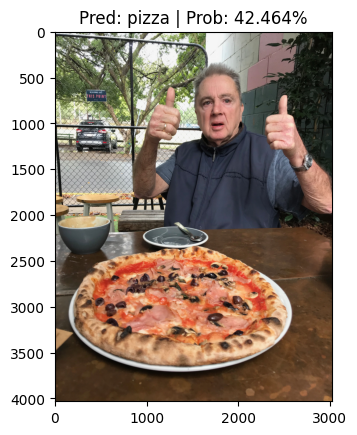

In [15]:
pred_and_plot_image(
    model,
    image_path='data/pizza_steak_sushi/eval/04-pizza-dad.jpeg',
    class_names=class_names,
    image_size=(224,224),
    transform=auto_transforms,
    device='cpu',
)